## Phishing Email 的 POS

In [14]:
import stanza
from stanza.server import CoreNLPClient

import os
import pandas as pd

import nltk
from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import *
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from wordcloud import WordCloud

import re
import matplotlib.pyplot as plt

## 設定 CoreNLP

In [2]:
# stanza.install_corenlp("./stanza_corenlp") # 下載coreNLP模型，預設會在/stanza_corenlp裡面

2024-05-18 12:51:54 WARNING: Directory ./stanza_corenlp already exists. Please install CoreNLP to a new directory.


In [2]:
os.environ['CORENLP_HOME'] = "./stanza_corenlp" # 因為自訂下載路徑，所以要設定環境參數

In [6]:
## 讀取文章
mails_df = pd.read_csv('dataset/Phishing_Email.csv')

In [ ]:
# 刪除標點符號/數字/換行符號
mails_df["Email Text"] = mails_df["Email Text"].apply(lambda x: re.sub(r'[^\w\s]','', str(x)))  #只留下英文字母和空格(包含換行符號)
mails_df["Email Text"] = mails_df["Email Text"].apply(lambda x: re.sub(r'[\n_-]+',' ', x)) #將換行符號替換成空格

# 去除空值
mails_df = mails_df[mails_df["Email Text"] != 'empty']

# 把欄位名字變好聽
mails_df = mails_df.rename(columns={"Unnamed: 0":"index"})

mails_df.info()

In [ ]:
Phishing_mails = mails_df[mails_df["Email Type"] == 'Phishing Email']
Phishing_mails.info()

In [73]:
def get_nlp_result(df, text_col, id_col):    
    
    print("Starting a server with the Python \"with\" statement...")
    
    start = time.time()

    with CoreNLPClient(
        # annotators = ['tokenize','ssplit', 'pos', 'lemma', 'ner','sentiment','entitymentions'],
        annotators = ['tokenize','ssplit', 'pos'],
        memory = '32G', endpoint = 'http://localhost:7777' , be_quiet=True, 
    ) as client:
        
        token_list = []        
        for index, row in df.iterrows(): # document level  
            print(index)
            # send text into client
            document = client.annotate(row[text_col])                
            # print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")    
            
             # sentence level
            for i, sent in enumerate(document.sentence):                
                s = ""
                # token level
                for t in sent.token: 
                    s = s + " " + t.word # for sentence                
                    # print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))                
                    # save lemma, pos, ner
                    temp_token = [row[id_col],t.word, t.pos]     
                    token_list.append(temp_token) 


        token_table = pd.DataFrame(data=token_list, 
                            columns=[id_col, 'word', 'pos'])        

        end = time.time()

        print("time costing: {}".format(end - start))
        print("\nThe server should be stopped upon exit from the \"with\" statement.")

        # return token_table, senti_table , mention_table
        return token_table

In [ ]:
Phishing_mails.reset_index(drop=True)

In [121]:
# 8069 有12萬個字
Phishing_mails_new = Phishing_mails[Phishing_mails["index"] != 8069]

In [ ]:
# 跑POS
tokens1 = get_nlp_result(Phishing_mails_new, 'Email Text','index') # 資料框, 要處理的文字欄位名, id 欄位名

In [ ]:
tokens1.info()

In [ ]:
# 檢查筆數正不正確
print(f"total posts numbers: {len()}") # 62 篇

In [ ]:
# tokens1['pos'].unique()
pos_count = tokens1.groupby(['pos'])['pos'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
pos_count

In [128]:
# 儲存結果
tokens1.to_csv('dataset/Phishing_pos.csv', encoding = 'utf-8', index = False)

## 讀取POS資料集並分析

In [2]:
Phishing_pos = pd.read_csv("dataset/Phishing_pos.csv")
Phishing_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1801016 entries, 0 to 1801015
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   index   int64 
 1   word    object
 2   pos     object
dtypes: int64(1), object(2)
memory usage: 41.2+ MB


### 去除停用字 & 去除只有一個字母的

In [3]:
def is_single_english_letter(word):
    # 使用正則表達式匹配僅包含一個英文字母的字符串
    #return bool(re.fullmatch(r'[a-zA-Z]', word))
    return len(str(word)) <= 1

Phishing_pos = Phishing_pos[~Phishing_pos['word'].apply(is_single_english_letter)]

In [4]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 使用nltk的stop_words
stops = stopwords.words('english')
# 手動加入停用字
newStops = ['email','com','wa','ect','one','would','could','may','can','de','also','edu','ha']
stops.extend(newStops)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ariel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [97]:
Phishing_pos_noStop = Phishing_pos[~Phishing_pos['word'].isin(stops)]
Phishing_pos_noStop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1092670 entries, 0 to 1801015
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   index   1092670 non-null  int64 
 1   word    1092620 non-null  object
 2   pos     1092670 non-null  object
dtypes: int64(1), object(2)
memory usage: 33.3+ MB


## lemmatizing

In [101]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmaa = WordNetLemmatizer()
type(lemmaa)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ariel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ariel\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ariel\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


nltk.stem.wordnet.WordNetLemmatizer

In [15]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [16]:
text = "He was running and eating at same time. He has bad habit of hiking after playing long hours in the Sun."
tokens = nltk.word_tokenize(text)
print("原句的斷詞結果：\n", tokens)
tagged_tokens = nltk.pos_tag(tokens)
lemmatized_tokens = []
for token, tag in tagged_tokens:
    pos = get_wordnet_pos(tag)
    if pos:
        lemmatized_tokens.append(lemmaa.lemmatize(token, pos))
    else:
        lemmatized_tokens.append(lemmaa.lemmatize(token))
print("還原后：\n", lemmatized_tokens)

原句的斷詞結果：
 ['He', 'was', 'running', 'and', 'eating', 'at', 'same', 'time', '.', 'He', 'has', 'bad', 'habit', 'of', 'hiking', 'after', 'playing', 'long', 'hours', 'in', 'the', 'Sun', '.']
還原后：
 ['He', 'be', 'run', 'and', 'eat', 'at', 'same', 'time', '.', 'He', 'have', 'bad', 'habit', 'of', 'hike', 'after', 'play', 'long', 'hour', 'in', 'the', 'Sun', '.']


確認 lemmatizing 的效果後，對資料集所有詞性做 lemmatizing

In [103]:
def lemmatize_word(word):
    if isinstance(word, str):  # 确保输入是字符串
        token = nltk.word_tokenize(word)
        if token:  # 确保 token 列表非空
            tagged_token = nltk.pos_tag(token)[0]  # 这里假设每个词是独立的
            pos = get_wordnet_pos(tagged_token[1])
            if pos:
                return lemmaa.lemmatize(tagged_token[0], pos)
            else:
                return lemmaa.lemmatize(tagged_token[0])
    return word

In [102]:
lower_df = Phishing_pos_noStop.assign(word = Phishing_pos_noStop['word'].str.lower())
lower_df

,index,word,pos
0,3,hello,UH
4,3,hot,JJ
5,3,lil,NN
6,3,horny,JJ
7,3,toy,NN
...,...,...,...
1801011,18646,liveadulthosting,NN
1801012,18646,biz,NN
1801013,18646,lm,NNP
1801014,18646,signup,NN


In [113]:
lower_df['lemmatized'] = lower_df['word'].apply(lemmatize_word)
lower_df

,index,word,pos,lemmatized
0,3,hello,UH,hello
4,3,hot,JJ,hot
5,3,lil,NN,lil
6,3,horny,JJ,horny
7,3,toy,NN,toy
...,...,...,...,...
1801011,18646,liveadulthosting,NN,liveadulthosting
1801012,18646,biz,NN,biz
1801013,18646,lm,NNP,lm
1801014,18646,signup,NN,signup


### POS 種類分析
查看辨識出哪幾種POS

In [115]:
lower_df['pos'].unique()

array(['UH', 'JJ', 'NN', 'VBP', 'RB', 'VB', 'NNP', 'PRP', 'NNS', 'IN',
       'PRP$', 'VBN', 'RP', 'CD', 'ADD', 'JJR', 'VBD', 'VBG', 'VBZ',
       'JJS', 'FW', 'MD', 'PDT', 'NFP', 'CC', 'TO', 'NNPS', 'DT', 'AFX',
       'RBS', 'RBR', 'EX', 'WP$', 'WRB', 'WP', 'WDT', 'GW', 'SYM', '$',
       'LS'], dtype=object)

### POS 詞頻

#### POS 常見詞性列表
名詞對應：https://docs.datasaur.ai/assisted-labeling/ml-assisted-labeling/corenlp-pos
+ NN - 單數名詞 (e.g., dog, music, work)
+ JJ - 形容詞 (e.g., big, old, green)
+ NNS - 複數名詞 (e.g., dogs, songs, cars)
+ CD  - 基數 (e.g., one, two, 3)
+ VB - 動詞原形 (e.g., run, eat, be)
+ NNP - 專有名詞單數 (e.g., London, John)
+ RB - 副詞 (e.g., quickly, never, well)
+ VBN - 過去分詞 (e.g., run, eaten, been)
+ VBP - 現在式非第三人稱單數動詞 (e.g., run, eat, am)
+ VBG - 動名詞或現在分詞 (e.g., running, eating)
+ IN - 介詞或從屬連接詞 (e.g., in, of, like, since)
+ VBZ - 現在式第三人稱單數動詞 (e.g., runs, eats, is)
+ FW - 外來詞 (e.g., en route, faux pas)
+ VBD - 過去式動詞 (e.g., ran, ate, was)
+ DT - 限定詞 (e.g., the, a, an)
+ PRP - 人稱代詞 (e.g., I, he, she, they)
+ UH - 感嘆詞 (e.g., oh, wow, huh)
+ JJS - 最高級形容詞 (e.g., biggest, oldest)
+ GW - 標記 (e.g., hyphenated words)
+ MD - 情態動詞 (e.g., can, could, will)

In [118]:
freq_pos = pd.DataFrame(lower_df['pos'].value_counts()).reset_index()
freq_pos.head(20)

,pos,count
0,NN,414230
1,JJ,123035
2,NNS,107423
3,CD,78486
4,VB,74230
5,NNP,61807
6,RB,36422
7,VBN,35579
8,VBP,29416
9,VBG,26713


C:\Users\ariel\AppData\Local\Temp\ipykernel_15456\2302170945.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


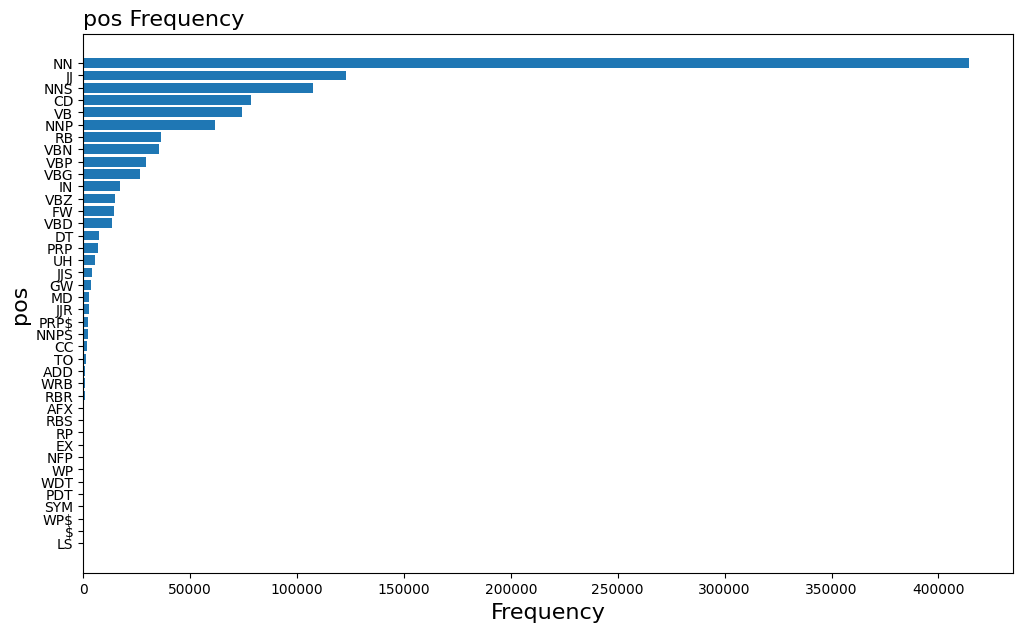

In [117]:
pos = freq_pos['pos']
count = freq_pos['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(pos, count)
ax.invert_yaxis()
ax.set_title('pos Frequency',loc ='left', size = 16)
ax.set_ylabel('pos', size = 16)
ax.set_xlabel('Frequency', size = 16)
fig.show()

可以看到在 Phishing Email 中，NN 單數一般名詞最多，其次為 JJ 形容詞與 NNS 複數一般名詞，為了正確計算詞頻，將做以下處理：<br>
- 合併 NN 單數一般名詞與 NNS 複數一般名詞，為 「NN 名詞」
- 合併 VB 動詞原型、 VBN 過去分詞、 VBP 現在式複數動詞、 VBG 動名詞或現在分詞、 VBZ 現在式單數動詞與 VBD 過去式動詞，為 「V 動詞」
- 基於英文文法，因此以下分析將不會納入 CD 基數

### 涉及到的名詞 (NN)

In [130]:
lower_df['pos_change'] = lower_df['pos']
lower_df.loc[lower_df['pos'] == "NNS", 'pos_change'] = "NN"
lower_df.loc[(lower_df['pos'] == "VB")|(lower_df['pos'] =="VBN")|(lower_df['pos'] =="VBP")|(lower_df['pos'] =="VBG")|(lower_df['pos'] =="VBZ")|(lower_df['pos'] =="VBD"), 'pos_change'] = "V"

In [138]:
# 篩選pos為專有名詞的資料
l_noun = ["NN"] 
noun = lower_df[lower_df.pos_change.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['lemmatized']].groupby(['lemmatized'])['lemmatized'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,lemmatized,count
9476,company,5055
21985,information,3774
28200,money,3705
6689,business,3614
1336,address,3540
42095,time,3513
26289,mail,3385
36025,report,3267
31003,order,2869
34199,program,2749


C:\Users\ariel\AppData\Local\Temp\ipykernel_15456\3604722321.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


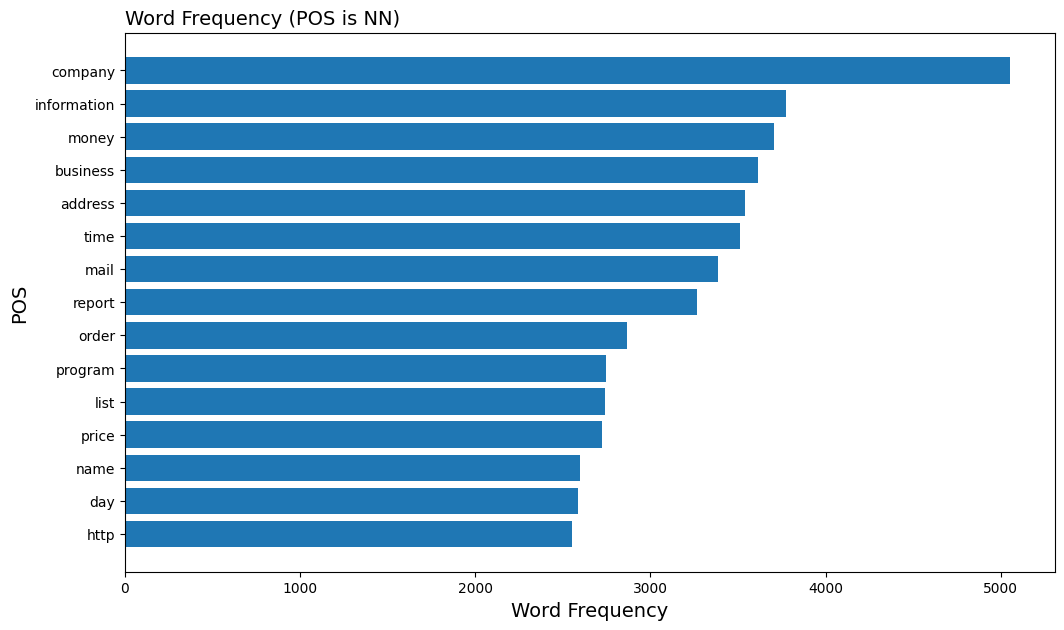

In [139]:
# 設定中文字形
# plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['lemmatized']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is NN)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

由上圖可得知在 Phishing Email 中的名詞
- 最多的是關於 company、business
- 其次是 information、money 和 time

### 涉及到的一般形容詞 (JJ)

In [140]:
# 篩選pos為專有名詞的資料
l_noun = ["JJ"] 
noun = lower_df[lower_df.pos_change.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['lemmatized']].groupby(['lemmatized'])['lemmatized'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,lemmatized,count
3706,free,4128
6157,new,2735
5607,many,1474
824,available,1241
3838,future,1128
6566,online,1110
3534,first,1066
6164,next,1041
4014,good,970
8475,special,949


C:\Users\ariel\AppData\Local\Temp\ipykernel_15456\4090952687.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


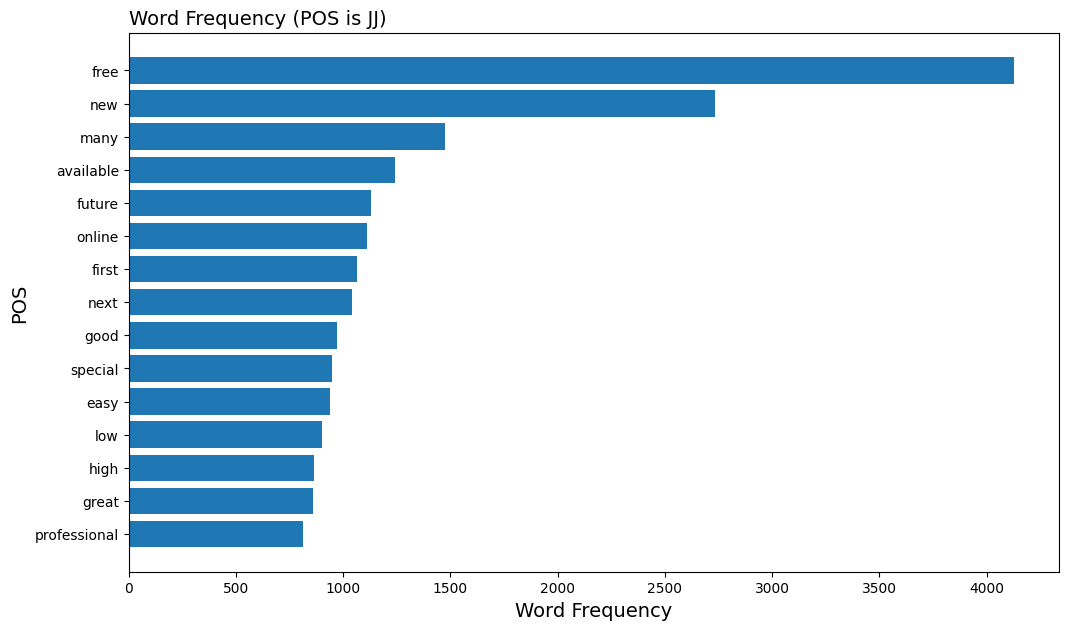

In [141]:
# 設定中文字形
# plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['lemmatized']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is JJ)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

由上圖可得知在 Phishing Email 中的一般形容詞
- 最多的是 free 
- 其次是 new、many 和 available

### 涉及到的最高級形容詞 (JJS)

In [148]:
# 篩選pos為專有名詞的資料
l_noun = ["JJS"] 
noun = lower_df[lower_df.pos.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['word']].groupby(['word'])['word'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,word,count
4,best,1781
71,latest,294
81,lowest,292
69,largest,147
39,fastest,133
57,highest,109
61,hottest,97
5,biggest,96
51,greatest,89
73,least,78


C:\Users\ariel\AppData\Local\Temp\ipykernel_15456\3244324859.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


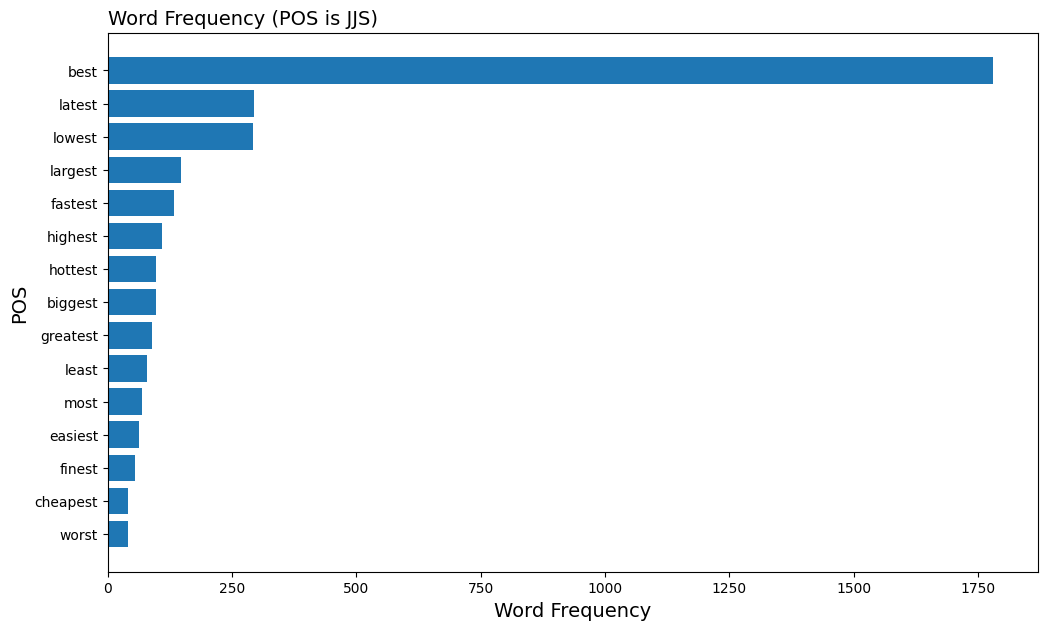

In [150]:
# 設定中文字形
# plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['word']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is JJS)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

由上圖可得知在 Phishing Email 中的最高級形容詞
- 最多的是 best 
- 其次是 latest、lowest 和 largest

### 涉及到的動詞 (V)

In [142]:
# 篩選pos為專有名詞的資料
l_noun = ["V"] 
noun = lower_df[lower_df.pos_change.isin(l_noun)]

# 計算每個名詞提到的次數，選出前15個
noun_count = noun[['lemmatized']].groupby(['lemmatized'])['lemmatized'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(15)
noun_count.head(10)

,lemmatized,count
3367,get,4828
4686,make,4818
5975,receive,3569
6661,send,2827
1435,click,2797
7854,use,2355
3408,go,2223
8028,want,2219
7393,take,2104
3951,include,2060


C:\Users\ariel\AppData\Local\Temp\ipykernel_15456\3655527052.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


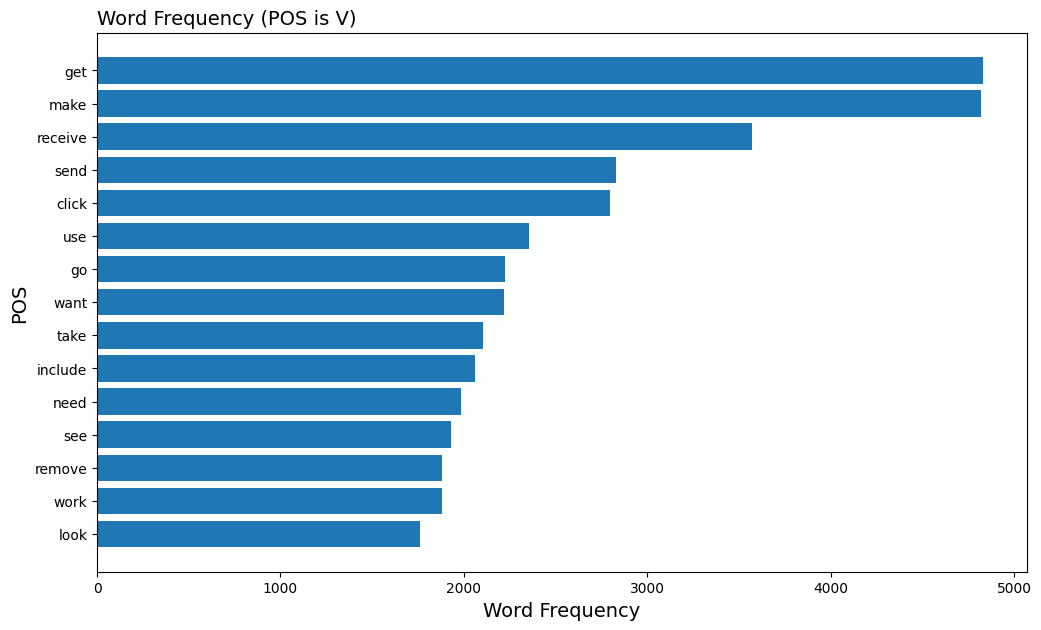

In [143]:
# 設定中文字形
# plt.rcParams['font.sans-serif'] = ['SimHei'] 
word = noun_count['lemmatized']
count = noun_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (POS is V)',loc ='left', size = 14)
ax.set_ylabel('POS', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

由上圖可得知在 Phishing Email 中的動詞
- 最多的是 get 
- 其次是 make、receive、send 和 click

### 結論
結合名詞、形容詞、動詞的 POS 分析結果推論：
1. 在 Phishing Email 中，大多的內容可能是提到公司（company、business）並給予收信者金錢（money）上的優惠，例如免費折扣（free）
2. 並接著強調這是最好（best）、最大（largest）的機會或最低（lowest）的折扣，有少部分 Phishing Email 則強調錯過不再（late），希望以此激起收信人的興趣
3. 並在文中提到請收信人點擊連結（click）、收下優惠（receive）、寄出回信（send）等，以獲得更多的資訊（information）
